In [88]:
import sys
import os

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. '/Users/darren/Documents/CSE493G1/GuitarTransformer/'
FOLDERNAME = '/Users/hua-hsinghuang/Documents/GitHub/GuitarTransformer/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

print(os.getcwd())

%cd $FOLDERNAME

/Users/hua-hsinghuang/Documents/GitHub/GuitarTransformer
/Users/hua-hsinghuang/Documents/GitHub/GuitarTransformer


/Users/hua-hsinghuang/Documents/GitHub/GuitarTransformer/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [182]:
import math
import torch
import torch.optim as optim
import torch.nn as nn

class PositionalEncoding(nn.Module):
    # Copy from here https://h-huang.github.io/tutorials/beginner/transformer_tutorial.html

    def __init__(self, dim_model, dropout_p=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout_p)

        pe = torch.zeros(max_len, dim_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0) / dim_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class DecoderOnlyTransformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        dim_model,
        num_heads,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
            batch_first=True
        )
        self.out = nn.Linear(dim_model, 2)
        
    def forward(self, tgt):

        # Using decoder only model, so create an zero tensor for the encoder
        src = torch.zeros_like(tgt)

        # decoder layer input
        tgt = self.positional_encoder(tgt)
        tgt_mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1).bool()
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask)
        out = self.out(transformer_out)
        
        return out


    def train_epoch(self, input_data, target_data, loss_fcn, optim, bs, init_len=200, up_fr=1000):
        """
        :param input_data: x examples with shape (num_examples, seq_length, features)
        :param target_data: y target with shape (num_examples, seq_length, features)
        :param loss_fcn: our loss function
        :param optim: our optimizer
        :param bs: batch size, number of examples per batch
        :param init_len: number of audio samples to initialize hidden state
        :param up_fr: number of timesteps before we backprop (truncated backprop)
        """
        # shuffle the examples around
        shuffle = torch.randperm(input_data.shape[0])

        # Iterate over the batches
        ep_loss = 0
        for batch_i in range(math.ceil(shuffle.shape[0] / bs)):
            
            # Load batch of shuffled segments
            input_batch = input_data[shuffle[batch_i * bs:(batch_i + 1) * bs], :, :]
            target_batch = target_data[shuffle[batch_i * bs:(batch_i + 1) * bs],:, :]
            
            # print(input_batch.shape)
            # Initialise network hidden state by processing some samples then zero the gradient buffers
            self(input_batch[:, 0:init_len, :])
            self.zero_grad()
            
            # Choose the starting index for processing the rest of the batch sequence, in chunks of args.up_fr
            start_i = init_len
            batch_loss = 0
            k = 0

            # Iterate over the remaining samples in the mini batch
            for k in range(math.ceil((input_batch.shape[1] - init_len) / up_fr)):
                # Process input batch with neural network
                
                input = input_batch[:, start_i:start_i + up_fr, :]
                output = self(input)

                # Calculate loss and update network parameters
                loss = loss_fcn(output, target_batch[:, start_i:start_i + up_fr, :])
                loss.backward()
                optim.step()

                # Set the network hidden state, to detach it from the computation graph
                # self.detach_hidden()
                self.zero_grad()

                # Update the start index for the next iteration and add the loss to the batch_loss total
                start_i += up_fr
                batch_loss += loss

            # Add the average batch loss to the epoch loss and reset the hidden states to zeros
            ep_loss += batch_loss / (k + 1)
            # self.reset_hidden()

        return ep_loss / (batch_i + 1)
    
    def process_data(self, input_data, target_data, loss_function, chuck_size):
        """
        :param input_data: x examples with shape (num_examples, seq_length, features)
        :param target_data: y target with shape (num_examples, seq_length, features)
        :param loss_fcn: our loss function
        :param chuck_size: the number of seq_length to process one time (avoid memory issue)
        """

        with torch.no_grad():

            # calculate the number of processing
            frame_len = target_data.size()[1]
            chuck_num = math.ceil(frame_len / chuck_size)

            # create empty output tensor
            output = torch.empty_like(target_data)

            # Iterate over chucks and process the input audio
            for l in range(chuck_num):
                # forward the input
                if l == chuck_num - 1: # the last loop
                    output[:, l * chuck_size:, :] = self(input_data[:, l * chuck_size:, :])
                else: # before the last loop
                    output[:, l * chuck_size:(l + 1) * chuck_size, :] = self(input_data[:, l * chuck_size:(l + 1) * chuck_size, :])
                
            # calucate the loss
            loss = loss_function(output, target_data)
        return output, loss

In [183]:
# model params
input_size = 2  # num features, 2 for stereo
output_size = 2  # num features, 2 for stereo
dim_model=2
num_heads=2
num_decoder_layers=1
dropout_p=0.1

# train params
batch_size = 30  # num examples per batch
init_len = 200  # num frames to process without backprop to init hidden state
up_fr = 1000  # num frames for truncated backprop
epochs = 30

# hyperparams
learn_rate = 1e-2

network = DecoderOnlyTransformer(dim_model=dim_model
                      , num_heads=num_heads
                      , num_decoder_layers=num_decoder_layers
                      , dropout_p=dropout_p)

if not torch.cuda.is_available():
    print('cuda device not available/not selected')
    cuda = 0
else:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.cuda.set_device(0)
    print('cuda device available')
    network = network.cuda()
    cuda = 1

# Set up training optimiser + scheduler + loss fcns and training info tracker
optimiser = optim.Adam(network.parameters(), lr=learn_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.5, patience=5, verbose=True)
loss_functions = nn.SmoothL1Loss()

cuda device not available/not selected


In [184]:
import audio

# load data
def audio_preprocessing(amplifier='ht1', data_type='train', frame_len=1):

    assert amplifier in ('ht1', 'muff') , "Amplifier should be either ht1 or muff"
    assert data_type in ('train', 'val', 'test') , "data_type should be either train , val or test"

    input_loc = f'./data/{data_type}/{amplifier}-input.wav'
    target_loc = f'./data/{data_type}/{amplifier}-target.wav'

    input_waveform = audio.load_audio(input_loc)
    target_waveform = audio.load_audio(target_loc)

    input_frames = audio.framify(input_waveform, frame_len)
    target_frames = audio.framify(target_waveform, frame_len)

    if data_type == 'train':
        seq_length = 22050
        X = audio.split_data(input_frames, seq_length)
        y = audio.split_data(target_frames, seq_length)

    else:
        frame_len = input_frames.shape[0]
        seq_length = frame_len//1
        X = audio.split_data(input_frames, seq_length)
        y = audio.split_data(target_frames, seq_length)

    return X, y

X_train, y_train = audio_preprocessing(amplifier='ht1', data_type='train')
X_val, y_val = audio_preprocessing(amplifier='ht1', data_type='val')
X_test, y_test = audio_preprocessing(amplifier='ht1', data_type='test')

In [189]:
X_train_small = X_train[:100, :1000, :]
y_train_small = y_train[:100, :1000, :]

X_val_small = X_val[:100, :1000, :]
y_val_small = y_val[:100, :1000, :]

X_test_small = X_test[:100, :1000, :]
y_test_small = y_test[:100, :1000, :]

In [186]:
print('training:', X_train.shape, y_train.shape)
print('validation: ', X_val.shape, y_val.shape)

print('training:', X_train_small.shape, y_train_small.shape)
print('validation: ', X_val_small.shape, y_val_small.shape)
# print('test: ', X_test.shape, y_test.shape)

training: torch.Size([680, 22050, 2]) torch.Size([680, 22050, 2])
validation:  torch.Size([1, 2251753, 2]) torch.Size([1, 2251753, 2])
training: torch.Size([100, 1000, 2]) torch.Size([100, 1000, 2])
validation:  torch.Size([1, 1000, 2]) torch.Size([1, 1000, 2])


In [187]:
# # TODO: train the model
# for epoch in range(30):
#     epoch_loss = network.train_epoch(X_train_small, y_train_small, loss_functions, optimiser, batch_size, init_len, up_fr)

#     print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")

# TODO: train the model
import time
from collections import defaultdict
import copy

res = defaultdict(list)
best_val_loss = float('inf')
best_model = None
best_ind = -1

# Train epochs
for epoch in range(epochs):

    ep_st_time = time.time()
    # train in training
    epoch_loss = network.train_epoch(X_train_small, y_train_small, loss_functions, optimiser, batch_size, init_len, up_fr)
    ep_end_time = time.time()

    val_st_time = time.time()
    # check validation result
    output, val_loss = network.process_data(X_val_small, y_val_small, loss_functions, chuck_size=1000)
    val_end_time = time.time()

    # save best model
    if val_loss < best_val_loss :
      best_model = copy.deepcopy(network)
      best_val_loss = val_loss
      best_ind = epoch

    res['epoch'].append(epoch+1)
    res['training_loss'].append(epoch_loss.item())
    res['training_time'].append(ep_end_time - ep_st_time)
    res['val_loss'].append(val_loss.item())
    res['val_time'].append(val_end_time - val_st_time)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss: .8f}, Val Loss: {val_loss: .8f}")

Epoch 1, Loss:  0.15776038, Val Loss:  0.11782236
Epoch 2, Loss:  0.13497360, Val Loss:  0.07372889
Epoch 3, Loss:  0.11458565, Val Loss:  0.05167424
Epoch 4, Loss:  0.09948844, Val Loss:  0.03685969
Epoch 5, Loss:  0.08628840, Val Loss:  0.02613921
Epoch 6, Loss:  0.07497108, Val Loss:  0.01672656
Epoch 7, Loss:  0.06411499, Val Loss:  0.00891746
Epoch 8, Loss:  0.05913059, Val Loss:  0.00346406
Epoch 9, Loss:  0.05303890, Val Loss:  0.00078595
Epoch 10, Loss:  0.05433101, Val Loss:  0.00030517
Epoch 11, Loss:  0.05071886, Val Loss:  0.00060726
Epoch 12, Loss:  0.05395345, Val Loss:  0.00076541
Epoch 13, Loss:  0.05417925, Val Loss:  0.00067339
Epoch 14, Loss:  0.05377663, Val Loss:  0.00053505
Epoch 15, Loss:  0.05266776, Val Loss:  0.00037133
Epoch 16, Loss:  0.05335756, Val Loss:  0.00022208
Epoch 17, Loss:  0.05278296, Val Loss:  0.00013415
Epoch 18, Loss:  0.05209795, Val Loss:  0.00005062
Epoch 19, Loss:  0.05309976, Val Loss:  0.00002695
Epoch 20, Loss:  0.05247553, Val Loss:  

In [188]:
import pandas as pd
res_table = pd.DataFrame(res)

training_time = res_table['training_time'].sum()
print(f'training_time for {epochs} epochs: {training_time} sec')
print(f'best epoch is {best_ind+1}')
res_table

training_time for 30 epochs: 540.0925631523132 sec
best epoch is 30


,epoch,training_loss,training_time,val_loss,val_time
0,1,0.157760,16.447260,0.117822,0.133465
1,2,0.134974,16.035561,0.073729,0.138475
2,3,0.114586,16.420363,0.051674,0.140332
3,4,0.099488,16.572735,0.036860,0.142447
4,5,0.086288,16.699088,0.026139,0.144273
5,6,0.074971,16.936329,0.016727,0.158044
6,7,0.064115,17.646360,0.008917,0.156786
7,8,0.059131,17.411422,0.003464,0.156614
8,9,0.053039,17.556373,0.000786,0.157523
9,10,0.054331,17.498740,0.000305,0.160329


In [190]:
test_st_time = time.time()
output, test_loss = best_model.process_data(X_test_small, y_test_small, loss_functions, chuck_size=1000)
test_end_time = time.time()
print(f'test loss: {test_loss:.6f}')
print(f'test time: {test_end_time - test_st_time} sec')

test loss: 0.000002
test time: 0.16266107559204102 sec


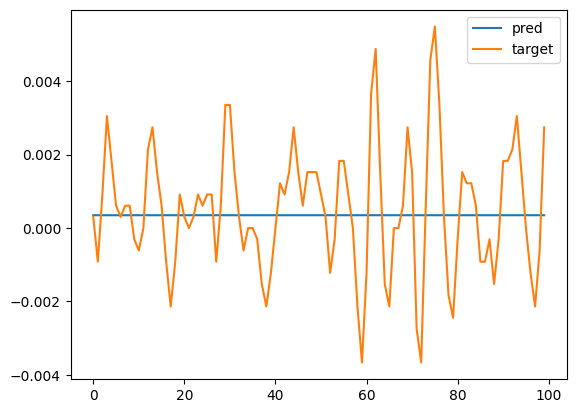

In [195]:
import matplotlib.pyplot as plt
y_test_pred = output[0, :, 0][:100]
y_test_true = y_test[0, :, 0][:100]
plt.plot(range(len(y_test_pred)), y_test_pred, label='pred')
plt.plot(range(len(y_test_true)), y_test_true, label='target')
plt.legend()